# Introduction
The asset universe for a typical arbitrage strategy is often substantial and as more financial securities are traded, the universe of potential pairs continues to balloon in size. This increase in size leads to more instances of spurious correlations among financial securities. To constrain the search universe and avoid spurious correlations, Sarmento and Horta outline an unsupervised clustering approach to find securities for pairs trading in their book: <a href="https://www.springer.com/gp/book/9783030472504#aboutBook"> “A Machine Learning based Pairs Trading Investment Strategy.”</a>

This notebook is an inspiration following the work laid out in the book, wherein its central idea of pair selection methodology is utilized and validated via backtesting performance assessment.  
  
The research notebook is divided into the following sections:
<ol>
    <li>Data Processing </li>
    <li>Dimensionality Reduction </li>
    <li>Unsupervised Learning</li>
    <li>Select Pairs</li>
    <li>Trade Signal Generation </li>
    <li>Backtest </li>
    <li>Performance Summary </li>
    <li>Conclusion </li>
</ol>

# 

### Load Packages

In [1]:
import numpy as np
import pandas as pd
from mlpairs import * 


# Data Processing

Historical Daily closes of 1326 US Equites on the New York Stock Exchange from 2010.  
Data source: **stooq.com**

In [2]:
prices = pd.read_csv("US_NYSE_Daily_2010.csv", parse_dates=True, index_col=0)
# clean the data
prices.replace([np.inf, -np.inf], np.nan, inplace=True)
# interpolate missing values
prices.interpolate(source='spline', order=3, limit_direction='both', inplace=True)

print(prices.shape)

print("\nNumber of stocks:", len(prices.columns))
prices.head()

(3467, 1326)

Number of stocks: 1326


,A,AA,AAIC,AAP,AB,ABEV,ABG,ABM,ABR,ABT,...,WWW,WY,X,XIN,XOM,XPO,YPF,YUM,ZBH,ZTR
DATE,,,,,,,,,,,,,,,,,,,,,
2010-01-04,20.3327,34.4314,4.1166,36.7396,11.2826,3.3582,11.83,16.5308,0.775618,20.3065,...,11.9714,10.5850,52.5285,24.705,43.0324,1.76978,38.541,20.1407,54.7893,4.10086
2010-01-05,20.1135,33.3600,4.2030,36.5197,11.2730,3.3327,12.39,16.3028,0.755962,20.1459,...,11.7984,10.8105,52.4539,25.198,43.2036,1.76978,37.849,20.0687,56.5215,4.10086
2010-01-06,20.0397,35.0942,4.2001,36.8373,11.2759,3.3503,12.76,16.3028,0.842471,20.2530,...,11.8478,10.6914,54.7876,25.750,43.5761,1.72831,38.643,19.9268,56.5036,4.11205
2010-01-07,20.0139,34.3498,4.1921,36.8287,11.2826,3.3163,13.05,16.5139,0.885773,20.4214,...,12.0090,10.6421,55.2474,25.581,43.4389,1.71446,38.273,19.9229,57.8057,4.10086
2010-01-08,20.0079,35.1955,4.2056,36.9780,11.6287,3.3560,13.15,16.4950,0.905431,20.5245,...,12.1080,10.5447,59.2660,25.198,43.2639,1.76978,38.773,19.9268,56.5872,4.13273


# Dimensionality Reduction

### Calculate log-return series


In [3]:
op = OpticsPairs(prices)
op.log_returns.head()

,A,AA,AAIC,AAP,AB,ABEV,ABG,ABM,ABR,ABT,...,WWW,WY,X,XIN,XOM,XPO,YPF,YUM,ZBH,ZTR
DATE,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.010839,-0.031611,0.020771,-0.006003,-0.000851,-0.007622,0.046251,-0.013888,-0.025669,-0.007940,...,-0.014557,0.021080,-0.001421,0.019759,0.003971,0.000000,-0.018118,-0.003581,0.031126,0.000000
2010-01-06,-0.003676,0.050678,-0.000690,0.008659,0.000257,0.005267,0.029426,0.000000,0.108348,0.005302,...,0.004178,-0.011078,0.043529,0.021670,0.008585,-0.023711,0.020761,-0.007096,-0.000317,0.002725
2010-01-07,-0.001288,-0.021440,-0.001907,-0.000233,0.000594,-0.010200,0.022473,0.012866,0.050121,0.008280,...,0.013514,-0.004622,0.008357,-0.006585,-0.003153,-0.008046,-0.009621,-0.000196,0.022783,-0.002725
2010-01-08,-0.000300,0.024322,0.003215,0.004046,0.030214,0.011900,0.007634,-0.001145,0.021950,0.005036,...,0.008210,-0.009194,0.070215,-0.015085,-0.004037,0.031757,0.012979,0.000196,-0.021305,0.007741
2010-01-11,0.000600,0.025039,-0.013791,-0.009988,0.020732,-0.011749,0.003795,-0.002282,0.021576,0.005205,...,-0.011095,0.006522,-0.037571,-0.026419,0.011178,0.000000,0.015915,0.017264,0.021872,-0.007741


### Apply PCA

Principal component analysis is applied to the scaled log-return series. The below graphs plot the loadings on of each security on the first five principal components. It is unsurprising that nearly every security has a similar loading on the first principal component. This component is generally interpreted as the “market” component of financial instruments which explains much of the variation in price movements across securities. Because our sample data consist of publicly traded U.S. equity listings, we expect to see the presence of this first principal component.

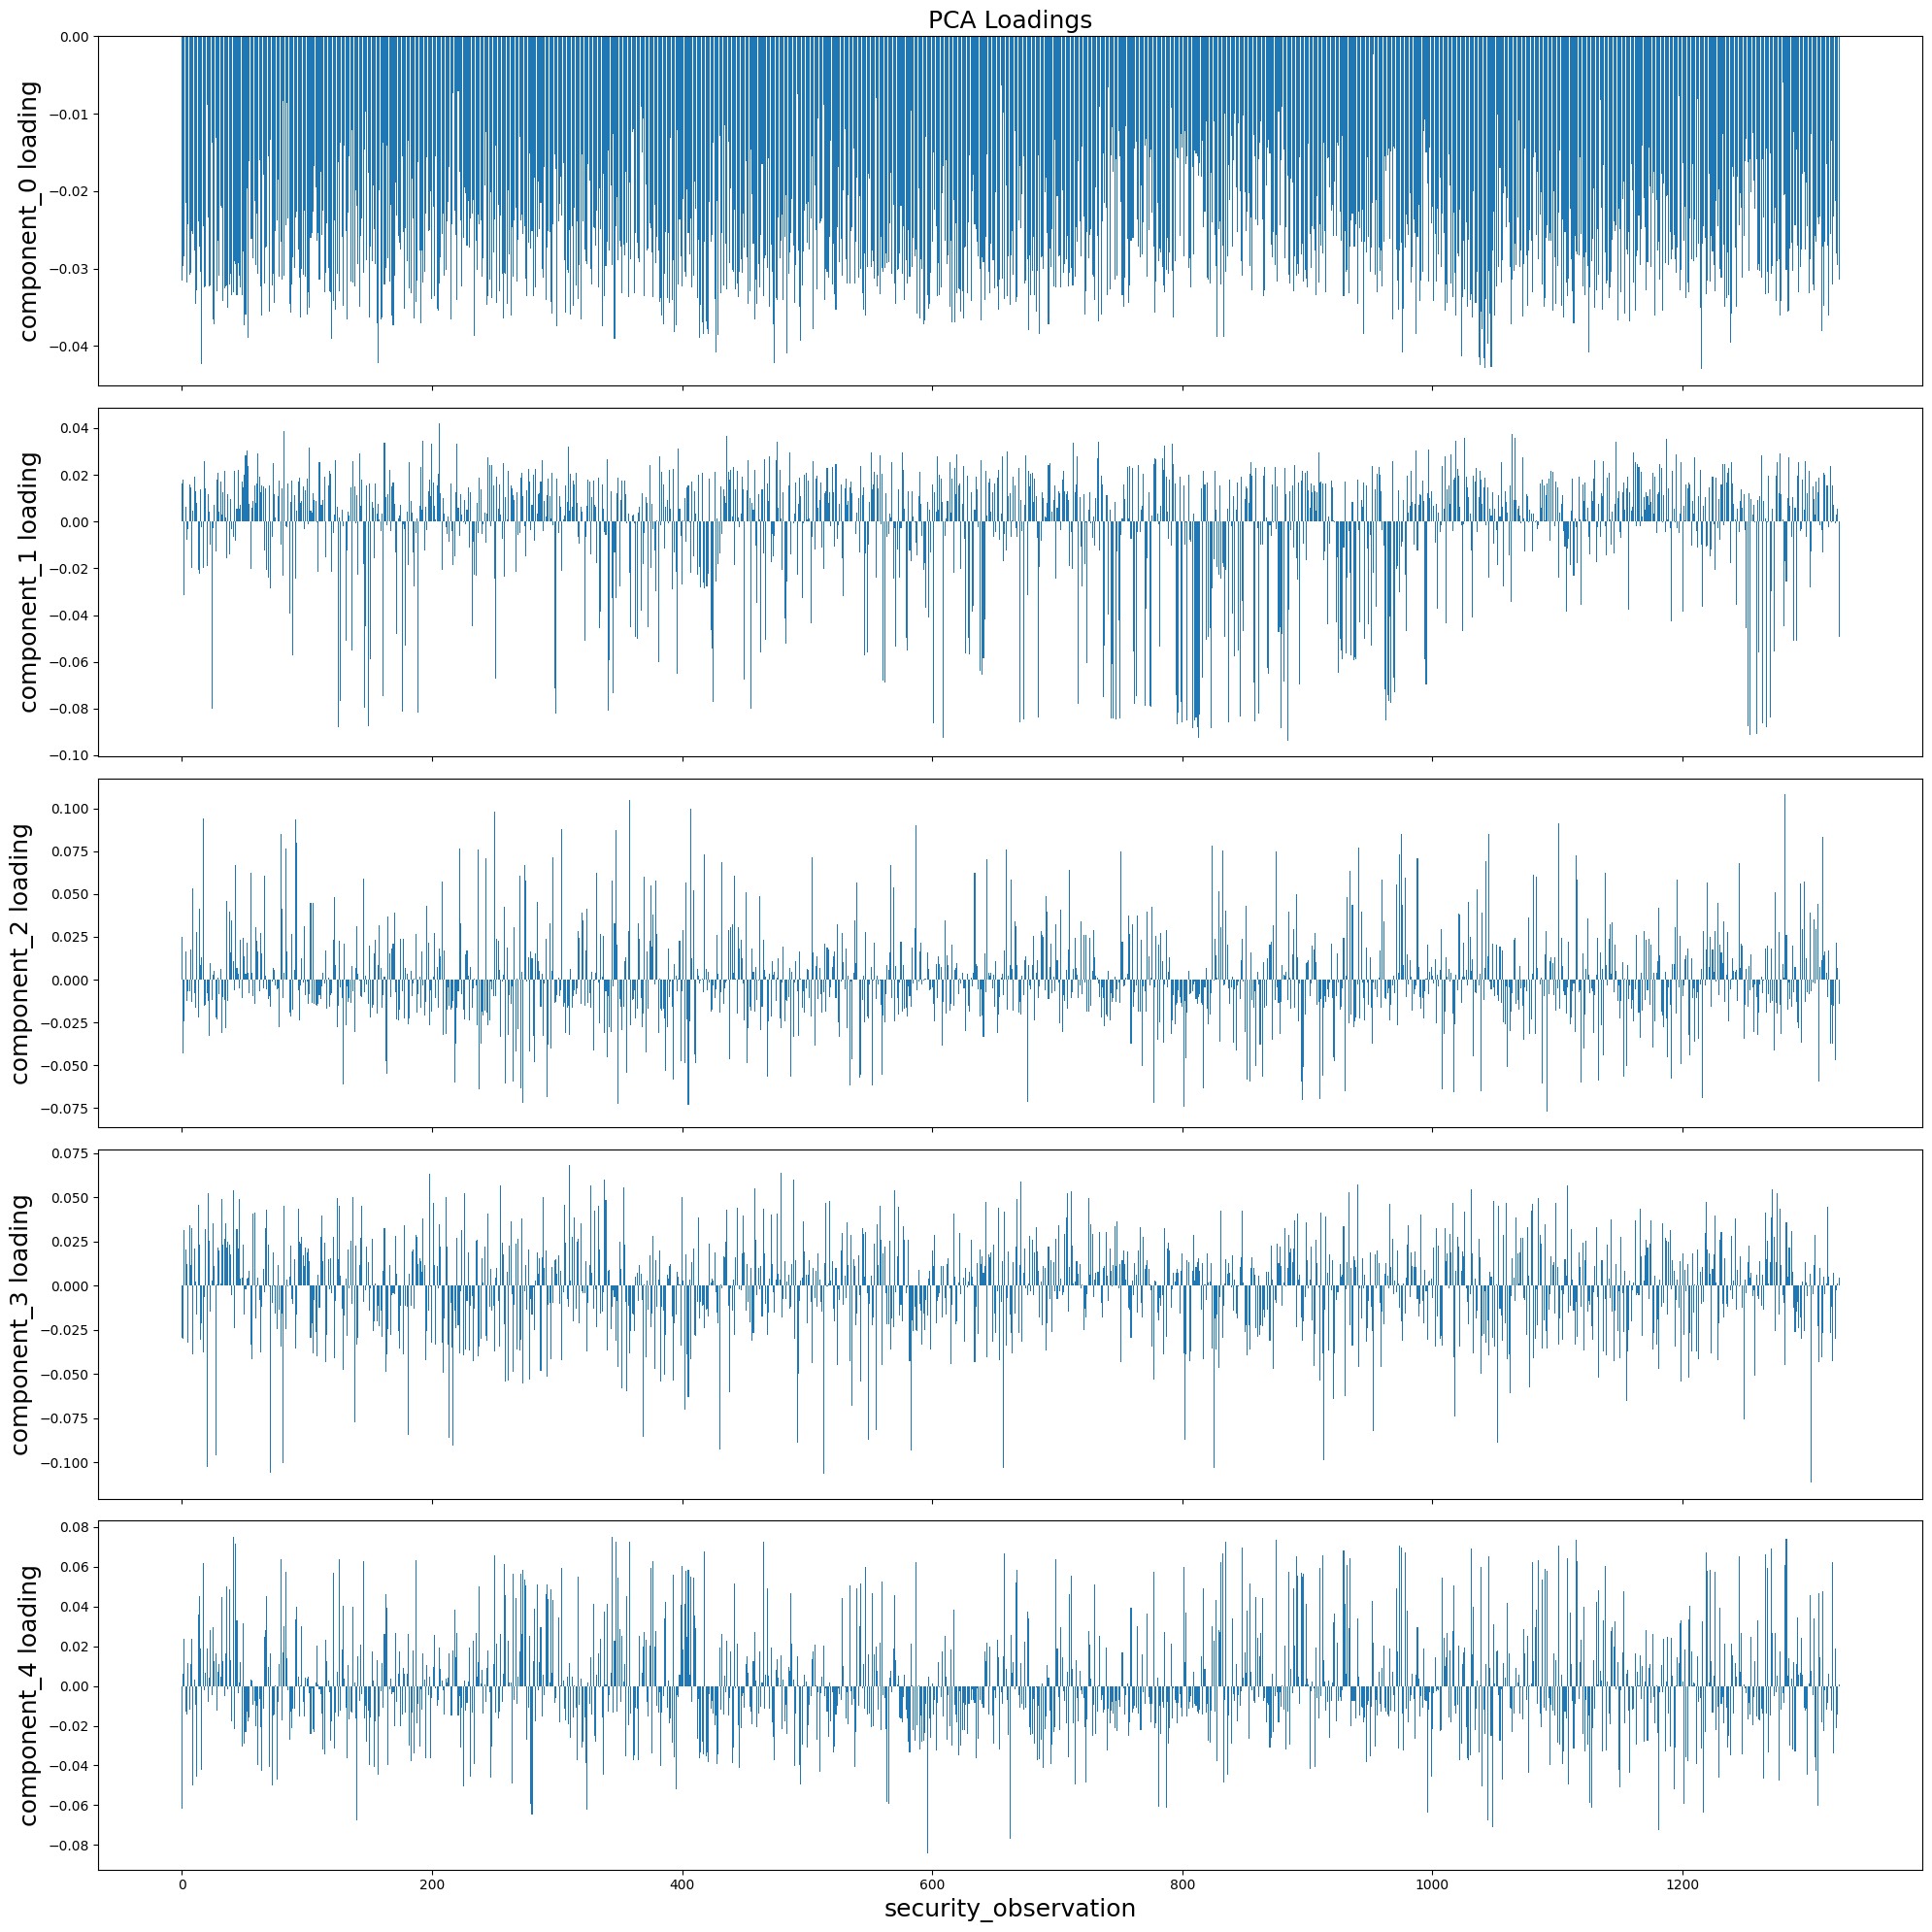

In [4]:
op.reduce_PCA(n_components_=15)
op.plot_loadings()

Implementing PCA reduced the dimensions of our data from 3467x1326 to 15x1326. Below we chart the cumulative variance explained by the 15 dimensions in component space. We see the “market” component explains roughly 37% of the variance in price movements.


Total variance explained: 51.0%


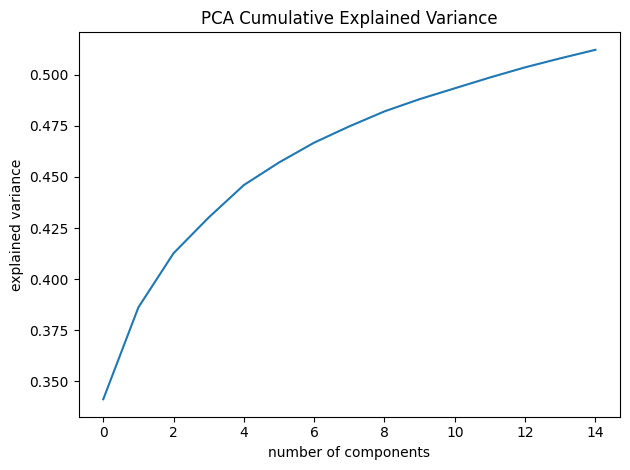

In [5]:
op.plot_explained_variance()
total_variance_explained = np.cumsum(op.explained_variance_ratio_)[-1]
print(f"Total variance explained: {round(total_variance_explained, 2)*100}%")

# Unsupervised Learning
### Apply OPTICS


Unlike other clustering algorithms, OPTICS computes an augmented cluster-ordering of the data rather than clustering the data explicitly. This frees the algorithm from relying on global parameters that might be heavily influenced by one cluster, but not accurately describe other clusters. The OPTICS algorithim introduced by Ankerst et. al in their publication: [OPTICS: Ordering Points To Identify the Clustering Structure](https://www.dbs.ifi.lmu.de/Publikationen/Papers/OPTICS.pdf).

A point $p$ is considered a core point if at least $MinPts$ are found within its $\epsilon$-neighborhood. Each point is given a core-dist which denotes the distance to the nearest $MinPts$th closest point. The calculation for core-dist is described below:<center>
 ${\displaystyle {\text{core-dist}}_{\mathit {\varepsilon ,MinPts}}(p)={\begin{cases}{\text{UNDEFINED}}&{\text{if }}|N_{\varepsilon }(p)|<{\mathit {MinPts}}\\{\mathit {MinPts}}{\text{-th smallest distance in }}N_{\varepsilon }(p)&{\text{otherwise}}\end{cases}}}$

The reachability-distance of another point $o$ from a point $p$ is either the distance between $o$ and $p$, or the core distance of $p$, whichever is bigger. The calculation for core-dist is described below:<center>
${\displaystyle {\text{reachability-dist}}_{\mathit {\varepsilon ,MinPts}}(o,p)={\begin{cases}{\text{UNDEFINED}}&{\text{if }}|N_{\varepsilon }(p)|<{\mathit {MinPts}}\\\max({\text{core-dist}}_{\mathit {\varepsilon ,MinPts}}(p),{\text{dist}}(p,o))&{\text{otherwise}}\end{cases}}}$

If $p$ and $o$ are nearest neighbors, this is the ${\displaystyle \varepsilon '<\varepsilon }$ we need to assume to have $p$ and $o$ belong to the same cluster.

### Generate clusters and find potential trading pairs
The OPTICS algorithm identified 2449 potential pairs of securities that share a common label generated from unsupervised learning.


In [6]:
op.find_pairs()
op.pairs

Found 2449 potential pairs


0          (A, ACN)
1          (A, BIO)
2           (A, BR)
3          (A, DHR)
4           (A, FI)
           ...     
2444     (GFI, KGC)
2445     (GFI, NEM)
2446    (GOLD, KGC)
2447    (GOLD, NEM)
2448     (KGC, NEM)
Length: 2449, dtype: object

### Plot clusters found

To visually inspect the clusters, we plot the loadings of the first two and first three principal components from each security. We can clearly see one cluster of securities that stands out from the rest in the lower right of the 2-dimensional graph. 

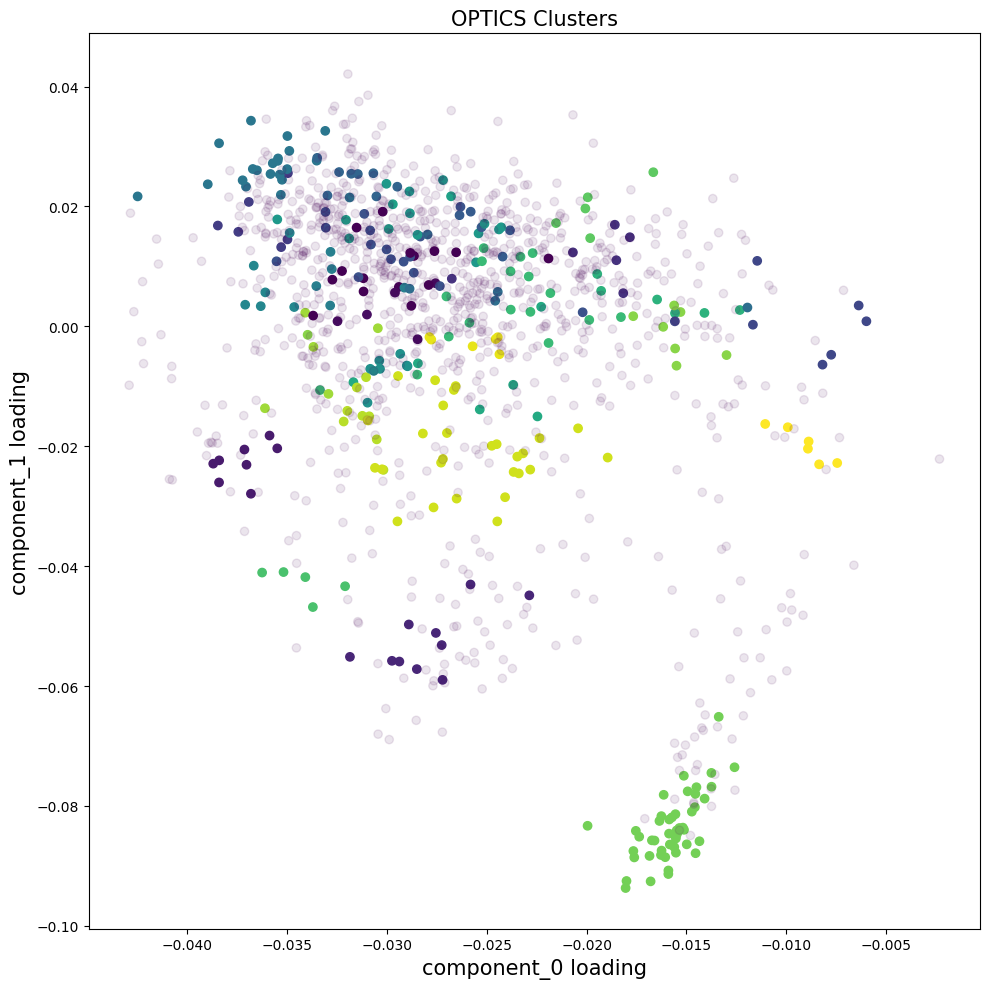

In [7]:
op.plot_clusters(n_dimensions=2)

Additionally, clusters can be distinguished more clearly in 3 dimensions when we add the third component.

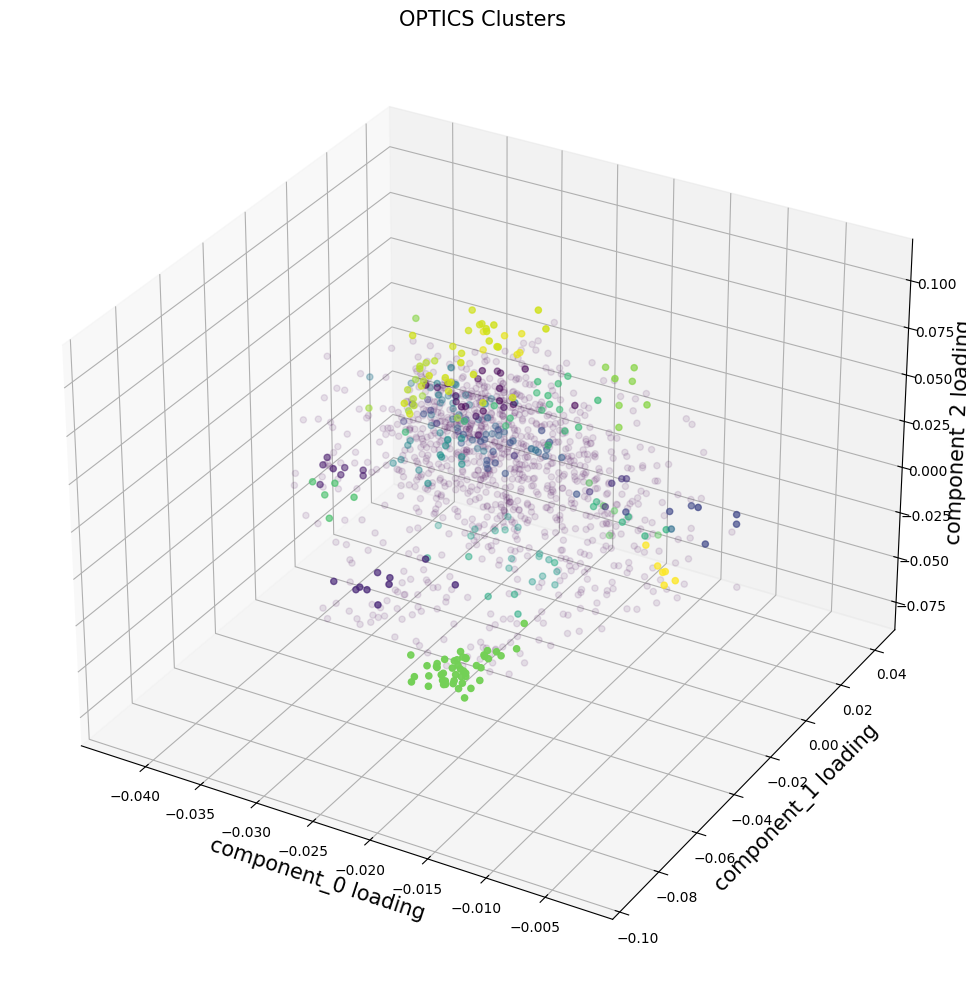

In [8]:
op.plot_clusters(n_dimensions=3)

The light points share a common label indicate data points considered noise and are excluded and the corresponding securities are excluded from the potential pairs list. 


# Select Pairs
### Apply Critera
Sarmento and Horta suggest four criteria to further filter the potential pairs to increase the probability of selecting pairs of securities whose prices will continue to mean revert in the future. 
To further mitigate risk, an additional *5th criterion* is added in this notebook which detects pairs that have overlapping securities and selects the pairs that have lower Hurst exponent coefficients.  

* Statistically significant t-stat from the Engle-Granger test (1% level)  
(In this implementation, we will use the more advanced Phillips-Ouliaris test)
* Hurst exponent < 0.5  
* Half-life between [1, 252]  
* Spread must cross the mean on average 12x per year  
* Remove overlapping-security pairs that have higher Hurst exponent coefficients.

These five criteria indicate positive characteristics for potential pairs of securities:  
-The Phillips-Ouliaris tests the pair for cointegration.  
-A Hurst exponent below 0.5 indicates that the pair of prices regresses strongly to the mean.   
-Pairs with extreme half-life values, less than 1 day or greater than 1 year, are excluded from the selected pairs. Extrem half-life values indicate a price series that either reverts too quickly or too slowly to be traded.    
-The price series must cross the long-term spread mean on average 12 times a year. This enforces one trade on average, per month.  
-Finally, ensure low portfolio's correlated risks by removing pairs with overlapping securities.



### Calculate potential pair statistics

In [9]:
op.calc_po_norm_spreads()
op.calc_hurst_exponents()
op.calc_half_lives()
op.calc_avg_cross_count()

### Filter potential pairs

In [10]:
op.filter_pairs()
op.filtered_pairs

Found 20 tradable pairs!


,pair,pvalue,alpha,beta,hurst_exp,half_life,avg_cross_count
147,"(AWF, HYB)",3.706771e-03,-0.489111,1.073778,0.297757,43.643419,14.464378
156,"(BLW, HYT)",1.345769e-10,-0.848619,1.188962,0.313420,20.253160,21.151428
160,"(CIF, DHF)",1.669520e-03,-0.400289,1.353555,0.329447,40.784654,17.226421
878,"(GRX, PFE)",5.926175e-03,1.171601,1.080962,0.419905,89.332640,12.356504
908,"(RFI, RNP)",2.690193e-03,-0.506622,1.352175,0.277815,41.267238,13.374099
1018,"(BLE, IIM)",1.593661e-06,-0.395635,1.107647,0.268533,28.066745,17.444476
1099,"(BTA, BYM)",1.142655e-03,-0.798315,1.253839,0.228600,34.685617,13.737525
1515,"(MFM, MYD)",4.025831e-05,-0.728104,0.988517,0.197947,26.697083,18.752812
1575,"(MHN, MYN)",6.250299e-12,0.204264,0.935186,0.216436,12.515369,23.331987
1600,"(MIY, MUJ)",1.156151e-10,-0.164490,1.059779,0.250736,16.787891,19.697721


The filtering criteria has substantially reduced the number of pairs to **20**.

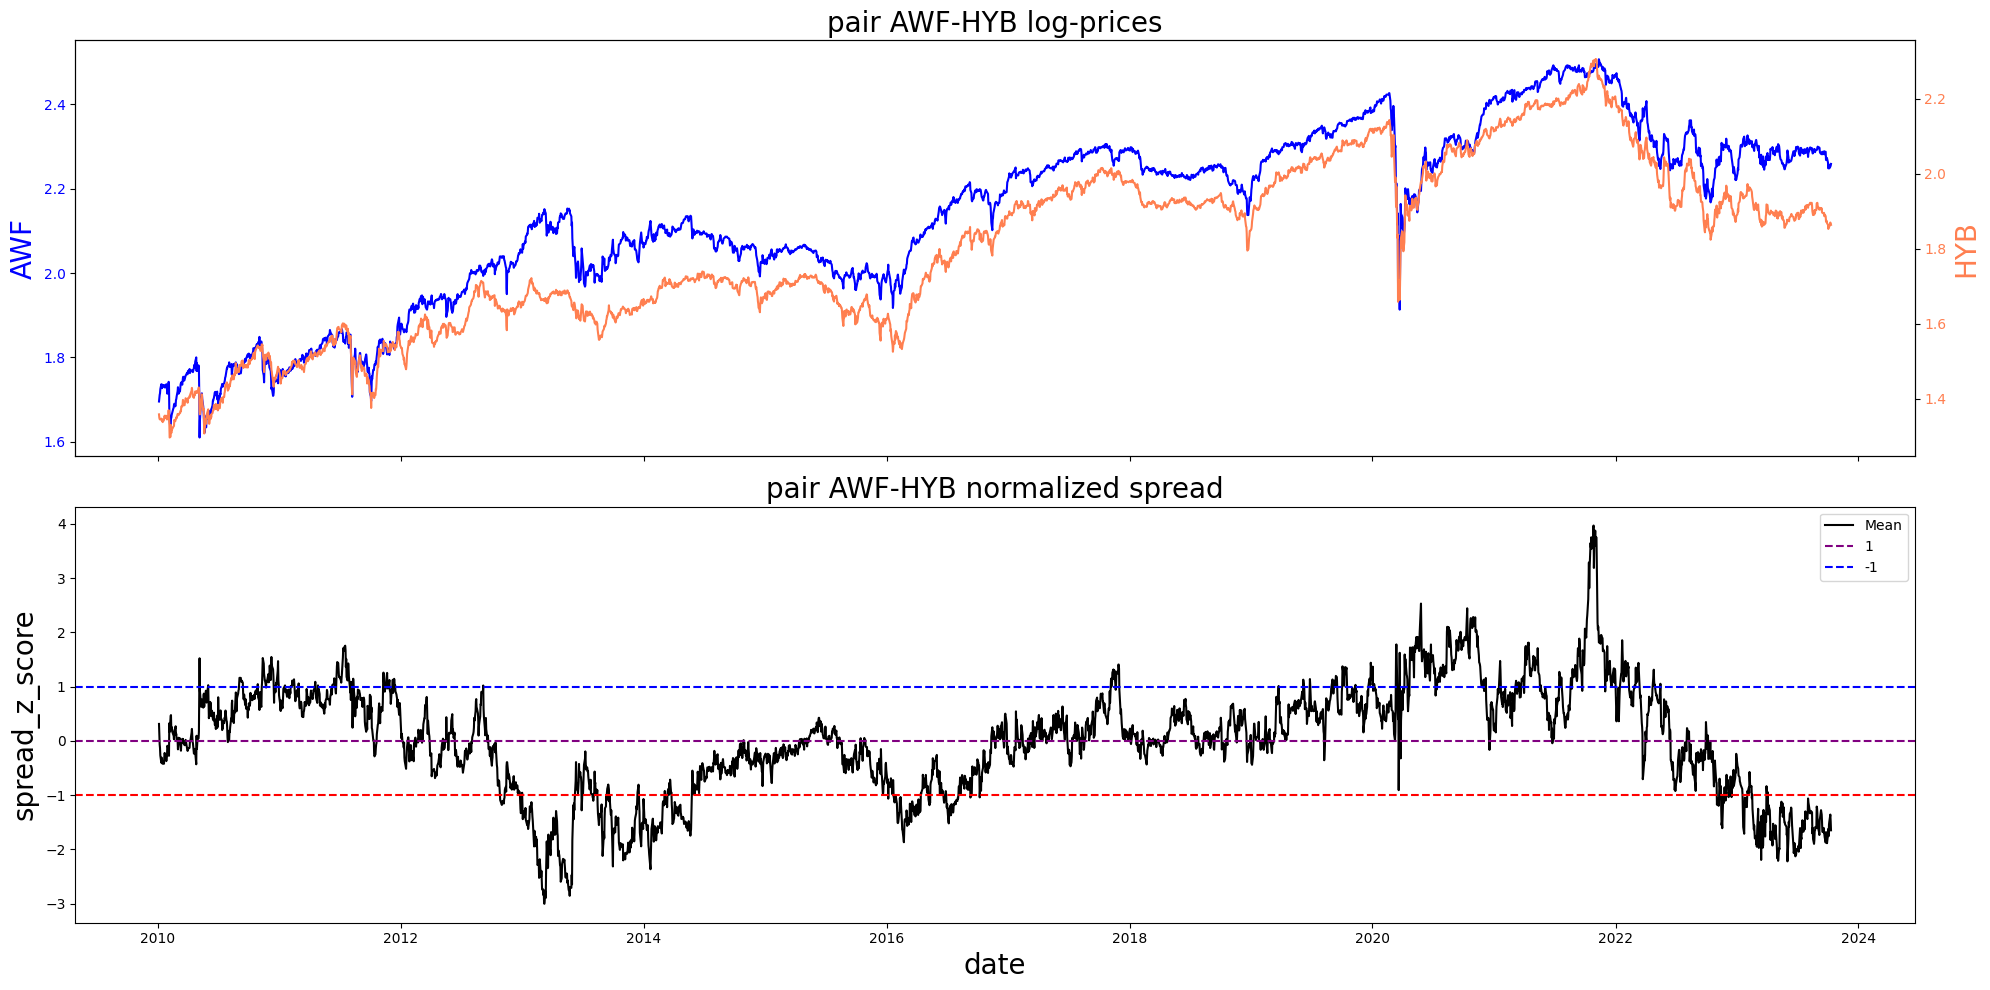

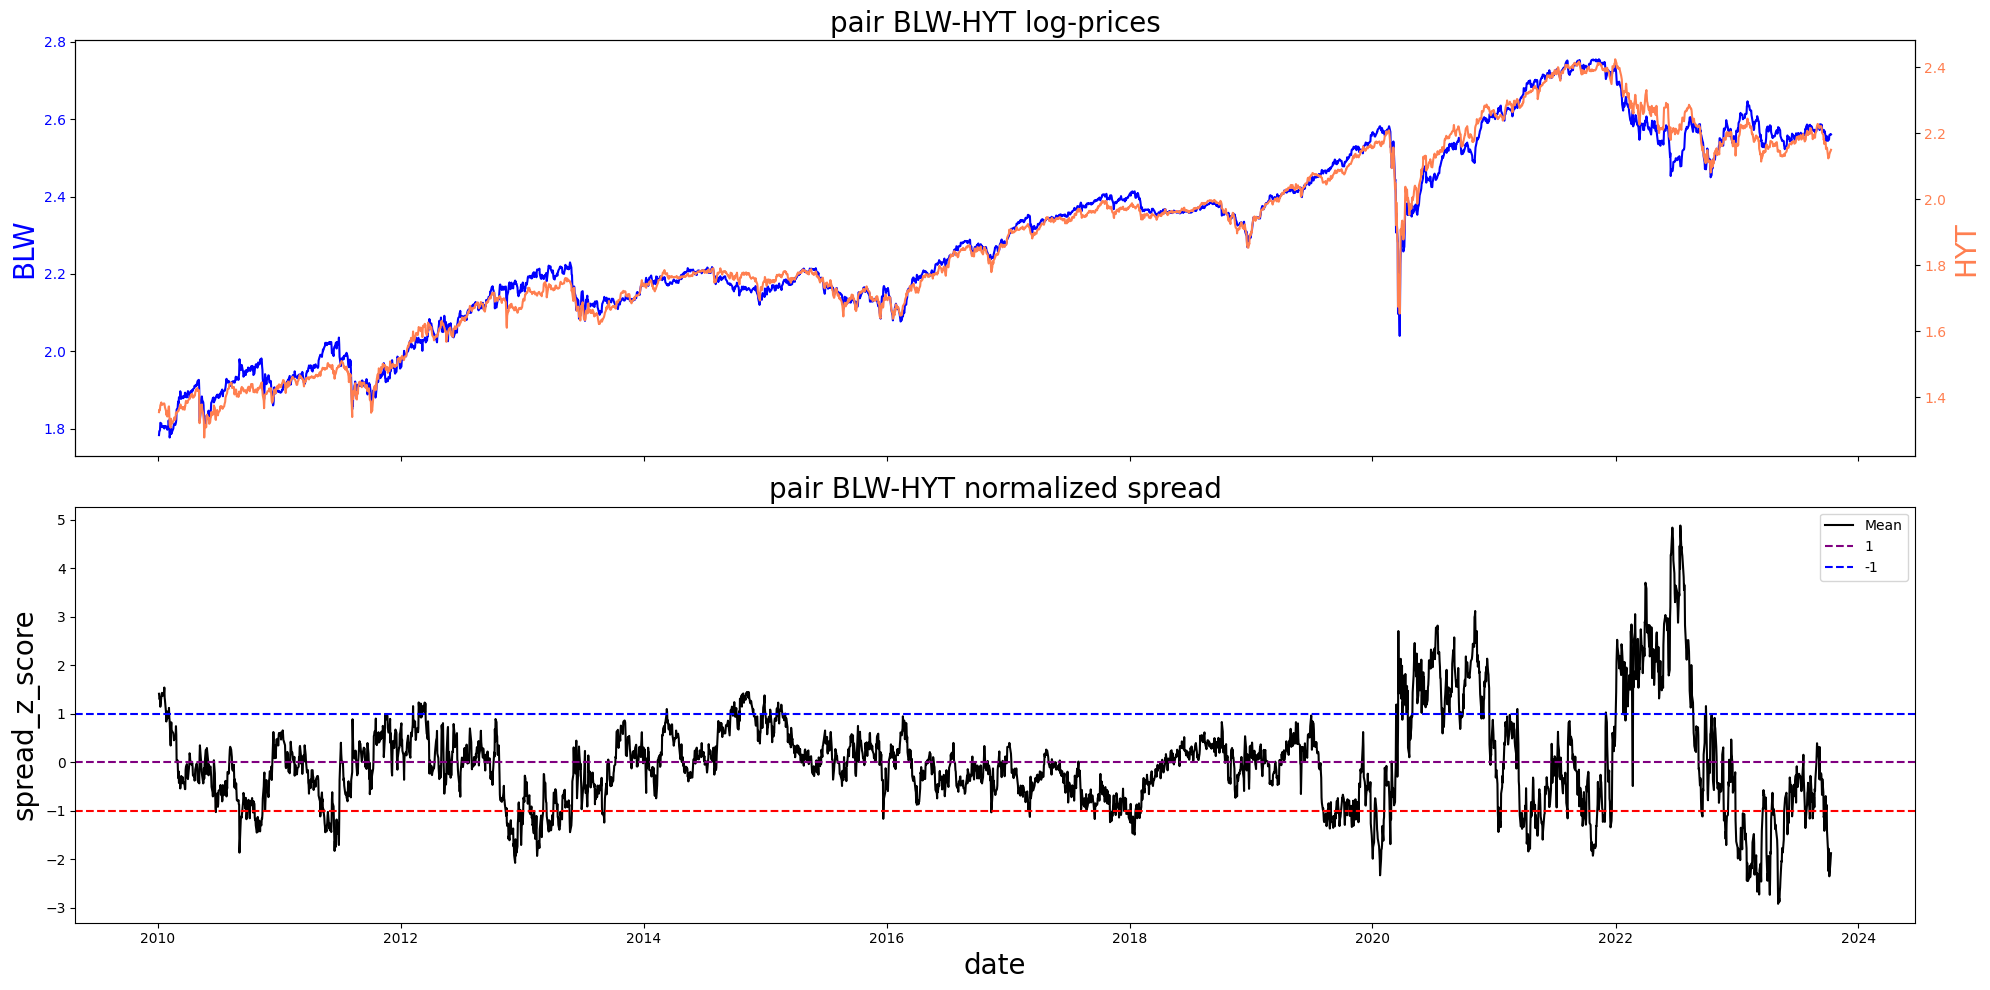

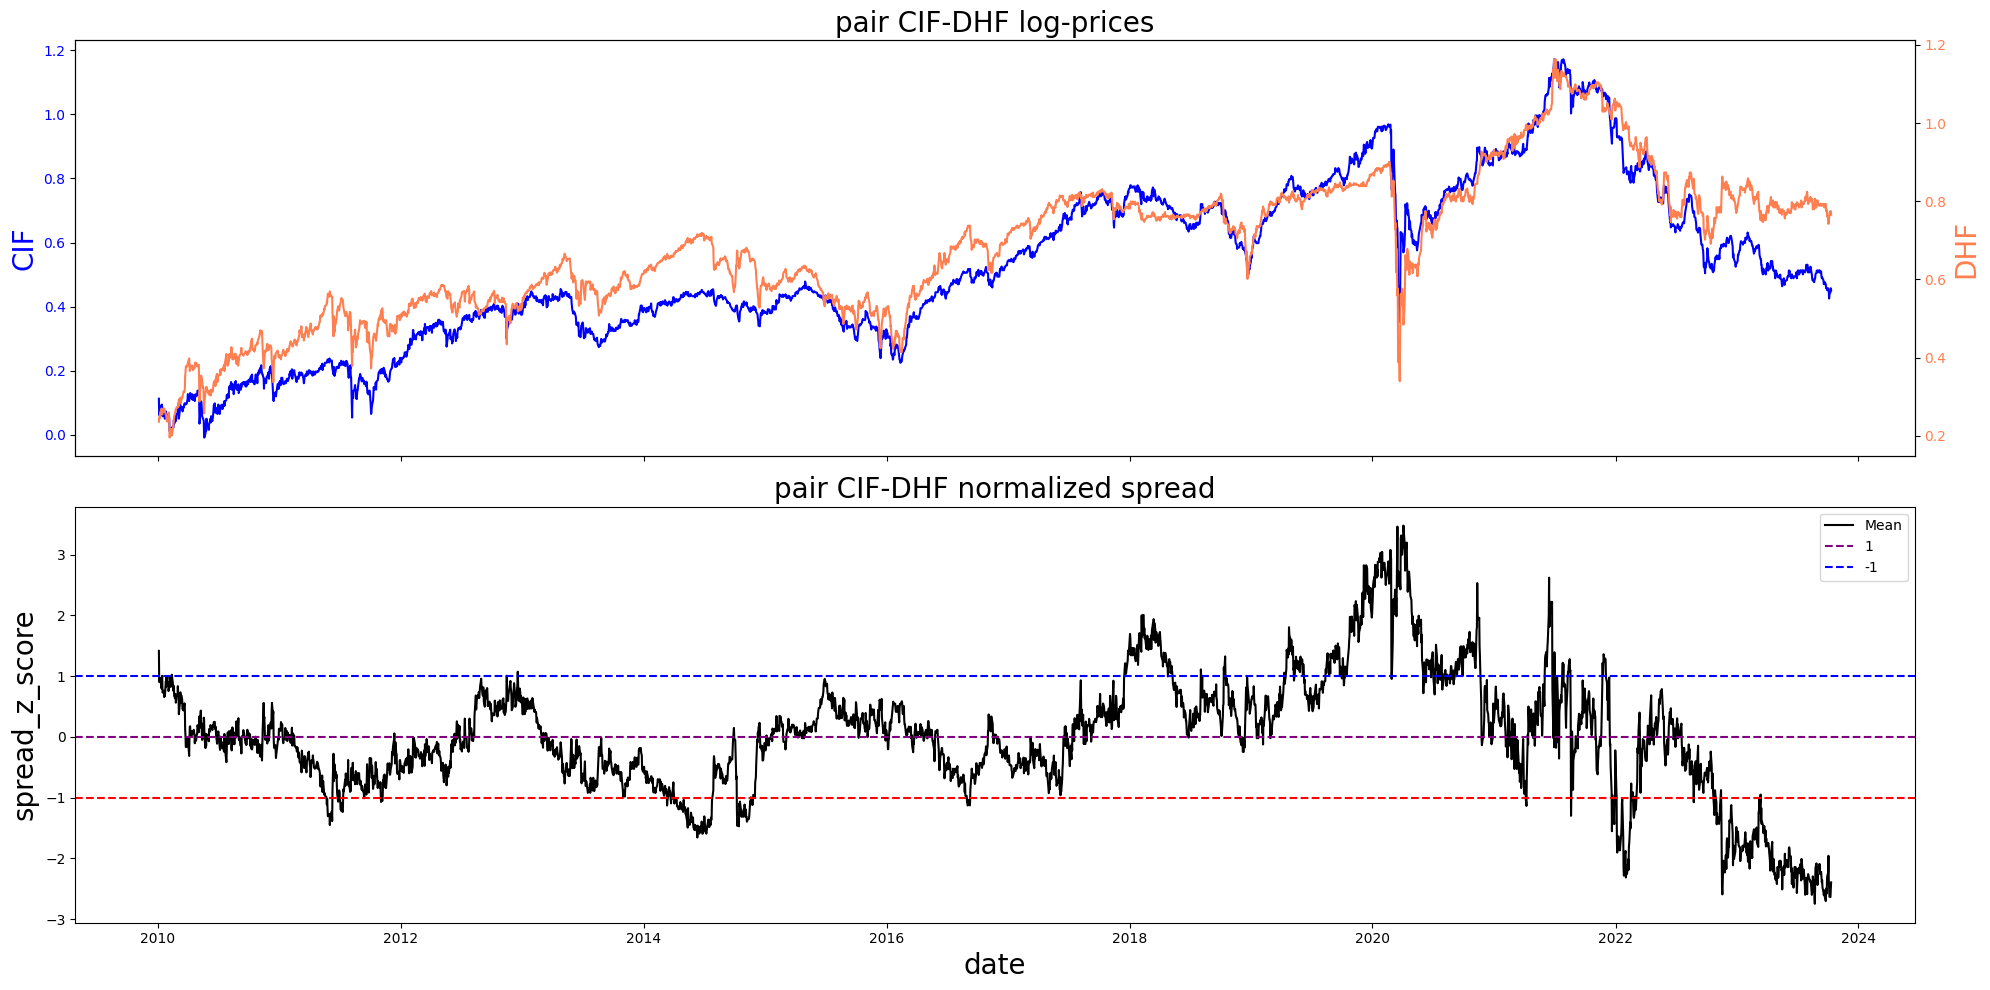

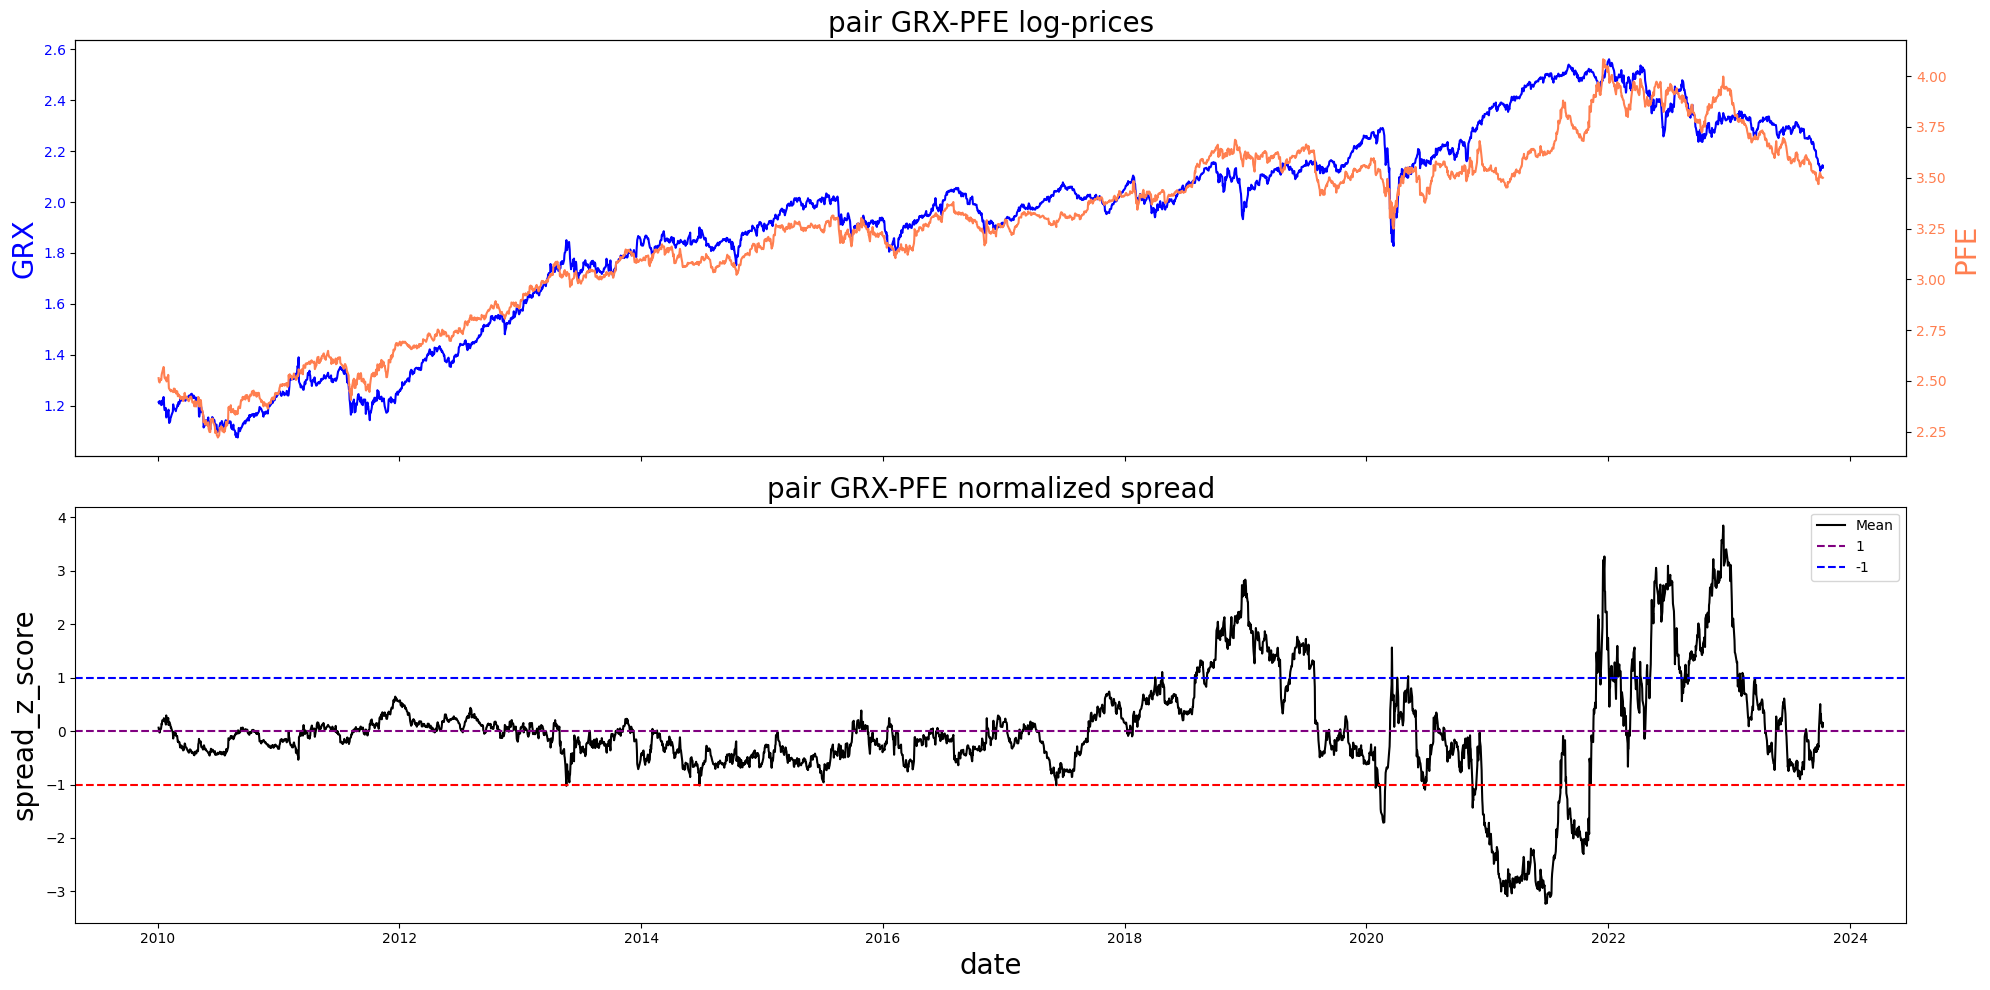

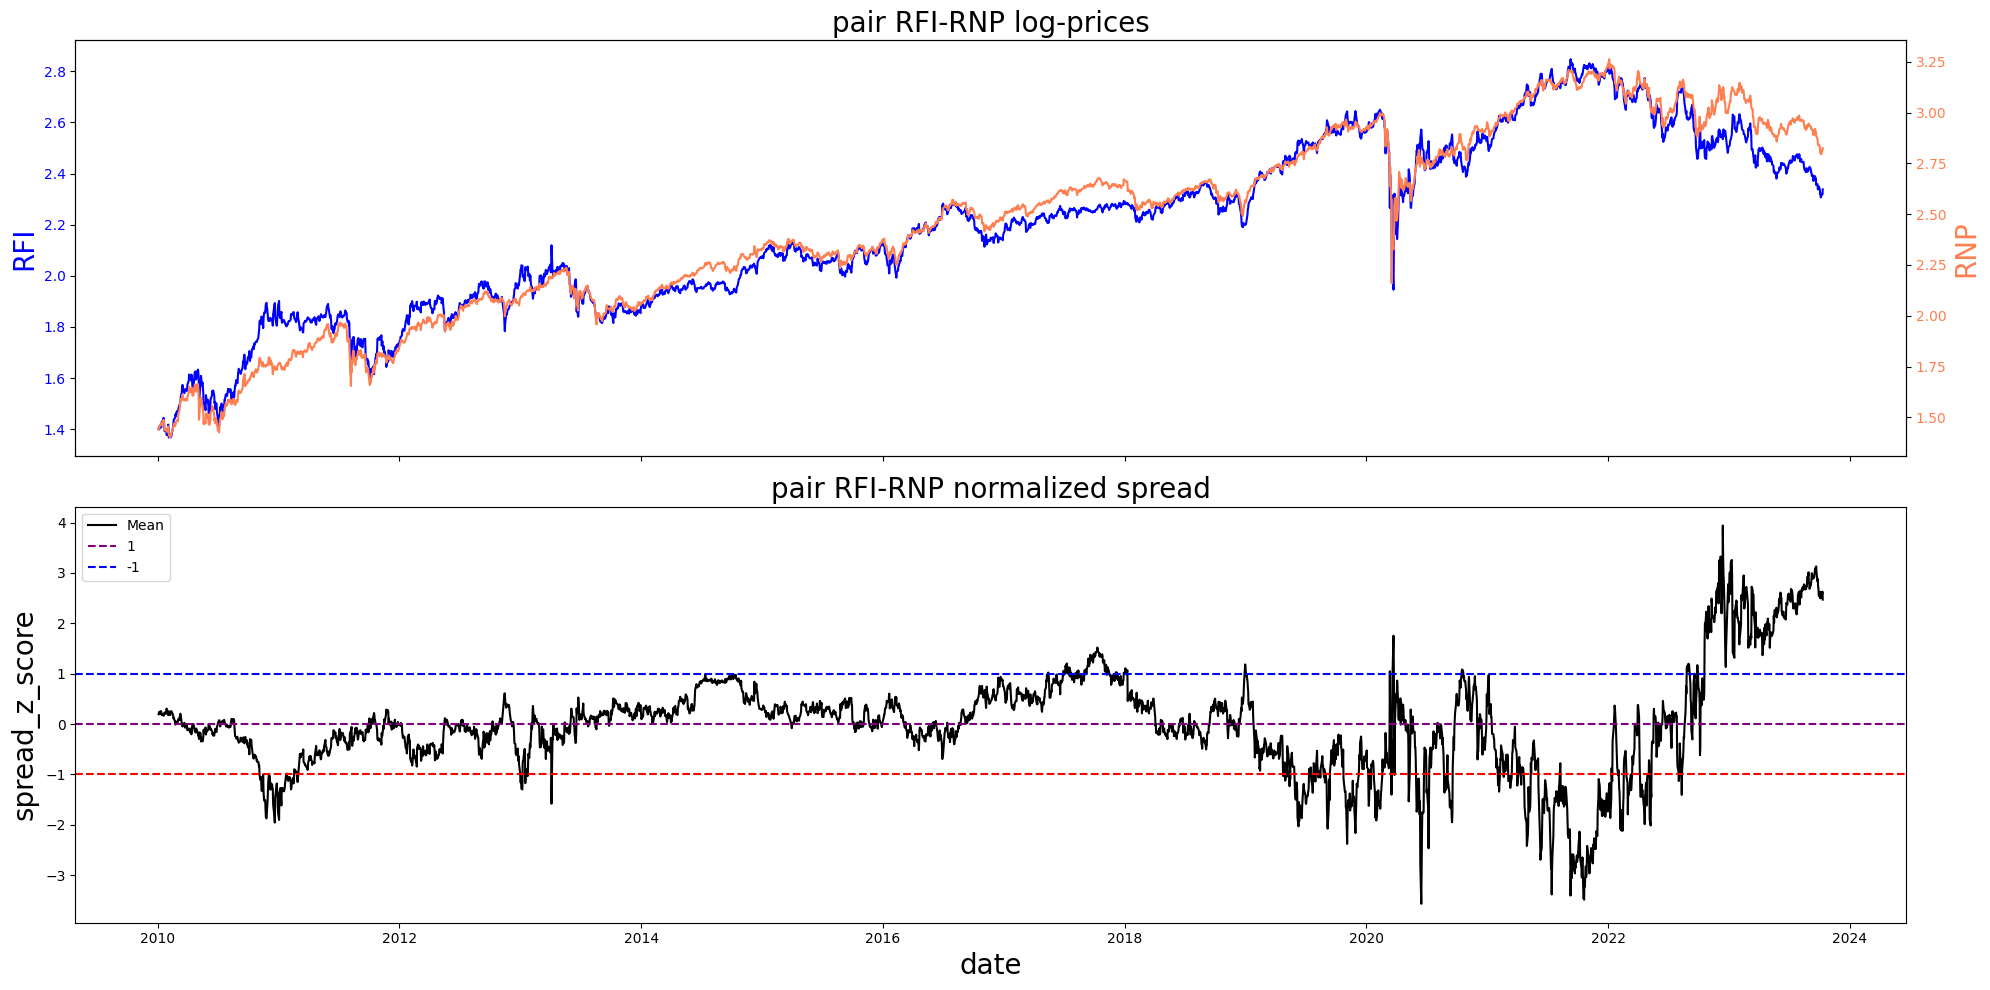

In [11]:
for i in op.filtered_pairs.index[:5]:
    op.plot_pair(idx=i)

# Backtest
This section will attempt to replicate the trading method described in Saremtno and Horta's paper: [Enhancing a Pairs Trading strategy with the application of Machine Learning](http://premio-vidigal.inesc.pt/pdf/SimaoSarmentoMSc-resumo.pdf).

Since the selected spreads has passed as stationary, we will use the ARMA(1,1) model to predict the next percentage change, denoted as: $\delta_{t+1}^{*}$ of individual spreads. Long (Short) signals are then generated if the predicted percentage change is below (above) certain predefined thresholds.  
  
The Upper (Lower) threshold $\alpha$ for the trading period is determined by the 90th (10th) percentile of Positive (Negative) percentage changes during the preceding training period, such that:   
  ${\displaystyle {\begin{cases}{\delta_{t+1}^{*}>\alpha_{U} : long}\\{\delta_{t+1}^{*}<\alpha_{L} : Short}\\{\text{Otherwise : Wait}}\end{cases}}}$   
    
The $Beta$ coefficients obtained from the training periods will be used as the Hedging Ratios during the following trading periods. The weighting of 2-leg positions is described in the snapshot below:  

<img src="Hedge_Ratio.png" alt="Position Weighting" style="width: 1000px;"/>  
  
Training window is **5 years** and trading window is **1 year**.    
**1:20 Leverage** is proposed in this backtest.

In [13]:
train_window = 252*5  
trade_window = 252 
backtest_result = {}
for i in range(train_window, len(prices)-trade_window, trade_window):
    train = prices.iloc[i-train_window:i]
    print("##################################################################")
    print("Train period:", train.index[0], train.index[-1])
    test = prices.iloc[i:i+trade_window+1]
    op = OpticsPairs(train)
    op.reduce_PCA(n_components_=15)
    op.find_pairs()
    op.calc_po_norm_spreads()
    op.calc_hurst_exponents()
    op.calc_half_lives()
    op.calc_avg_cross_count()
    op.filter_pairs()
    if len(op.filtered_pairs) != 0:
        print("Test period:", test.index[0], test.index[-1])
        print(f"Backtesting the following pairs:\n {list(op.filtered_pairs.pair)}")
        for j in op.filtered_pairs.index: 
            # get train_spread and threholds
            train_spread = op.norm_spreads[j]
            thrsLow = np.percentile(train_spread.pct_change()[1:], 10.0)
            thrsHigh = np.percentile(train_spread.pct_change()[1:], 90.0)
            # test
            S1 = test[op.filtered_pairs.pair[j][0]]
            S2 = test[op.filtered_pairs.pair[j][1]]
            pvalue, x, y = op.get_ols_variables(np.log(S1), np.log(S2))
            # Get parameters and calculate test_spread
            model = sm.OLS(y, x)
            result = model.fit()
            alpha, beta = result.params[0], result.params[1]
            spread = np.exp(y.T[0]) - np.exp(alpha + beta*x.T[1])
            test_spread = pd.Series(op.calc_zscore(spread), index=S1.index)
            backtest = trade(S1, S2, train_spread, test_spread, 0.25, 0.75, beta, fee=0.002)
            # append backtest results
            pair_name = f'{op.filtered_pairs.pair[j][0]}-{op.filtered_pairs.pair[j][1]}'
            if pair_name not in backtest_result.keys():
                backtest_result[pair_name] = []
            backtest_result[pair_name].append(backtest)

##################################################################
Train period: 2010-01-04 00:00:00 2015-01-05 00:00:00
Found 1412 potential pairs
Found 24 tradable pairs!
Test period: 2015-01-06 00:00:00 2016-01-06 00:00:00
Backtesting the following pairs:
 [('PH', 'ROK'), ('CCK', 'INGR'), ('BK', 'HIG'), ('MKL', 'MMC'), ('CI', 'COR'), ('WAL', 'WBS'), ('GEL', 'TYG'), ('KYN', 'MMP'), ('EQR', 'UDR'), ('KIM', 'SITC'), ('JRS', 'RQI'), ('ARR', 'NLY'), ('DHI', 'LEN'), ('AVA', 'D'), ('ED', 'SO'), ('ES', 'POR'), ('IDA', 'NEE'), ('PPL', 'RSPU'), ('EOT', 'NXJ'), ('MIY', 'NQP'), ('NKX', 'NUV'), ('CMU', 'CXE'), ('FMN', 'OIA'), ('AU', 'GOLD')]
##################################################################
Train period: 2011-01-03 00:00:00 2016-01-05 00:00:00
Found 4512 potential pairs
Found 47 tradable pairs!
Test period: 2016-01-06 00:00:00 2017-01-05 00:00:00
Backtesting the following pairs:
 [('BDJ', 'NIE'), ('EOI', 'JCE'), ('MCN', 'USA'), ('AIG', 'RJF'), ('AMP', 'COF'), ('FHN', 'JPM'), ('B

### First look at the PnL of the first 5 pairs

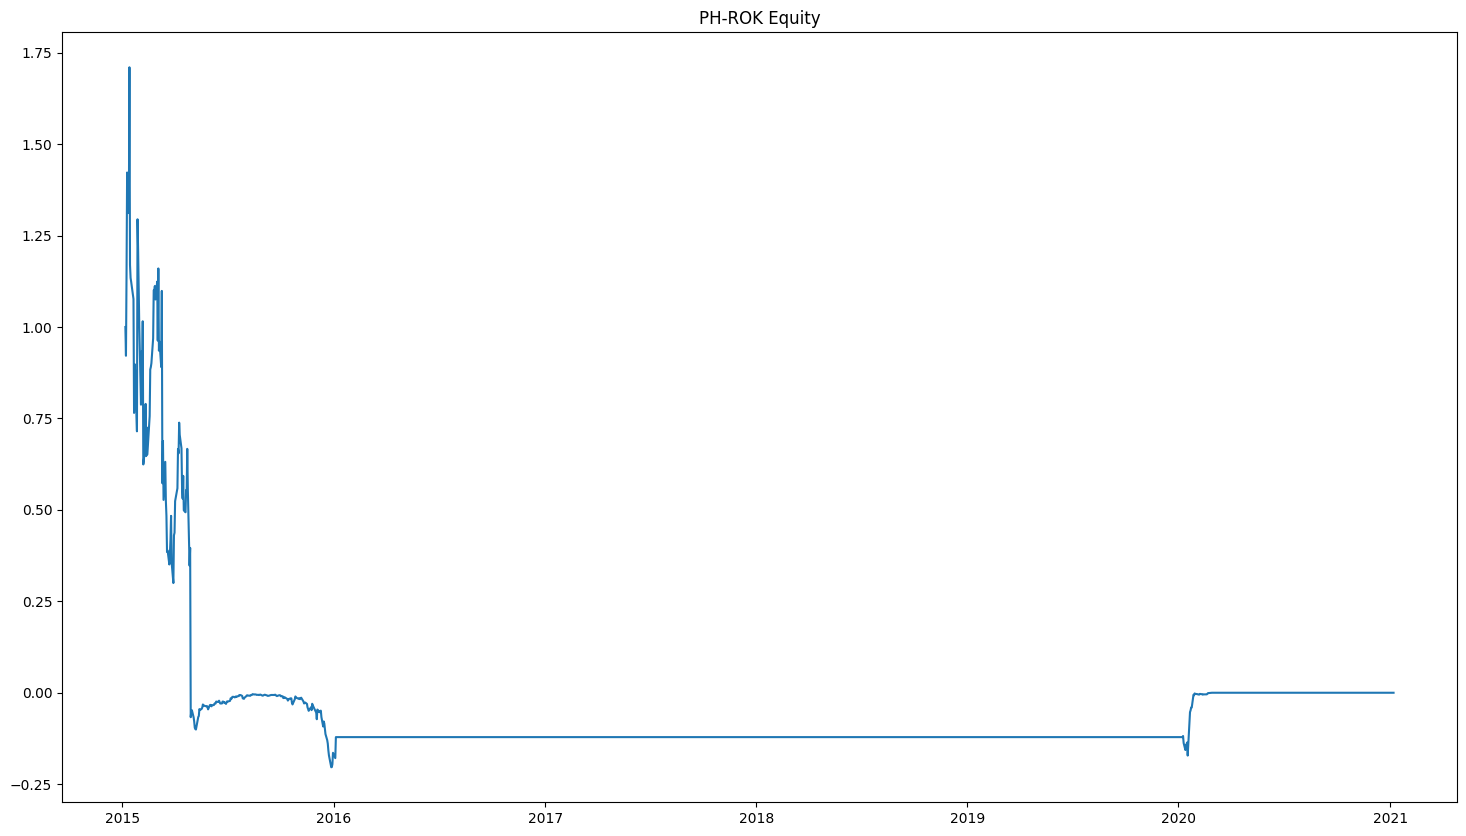

Total-Ret: -0.9999999999999994, Annual-Ret: -0.9999999747454541, Sharpe: -0.8211697932077024, 
maxDD: -1.1191453112723913, MaxDD-Duration: 500.0



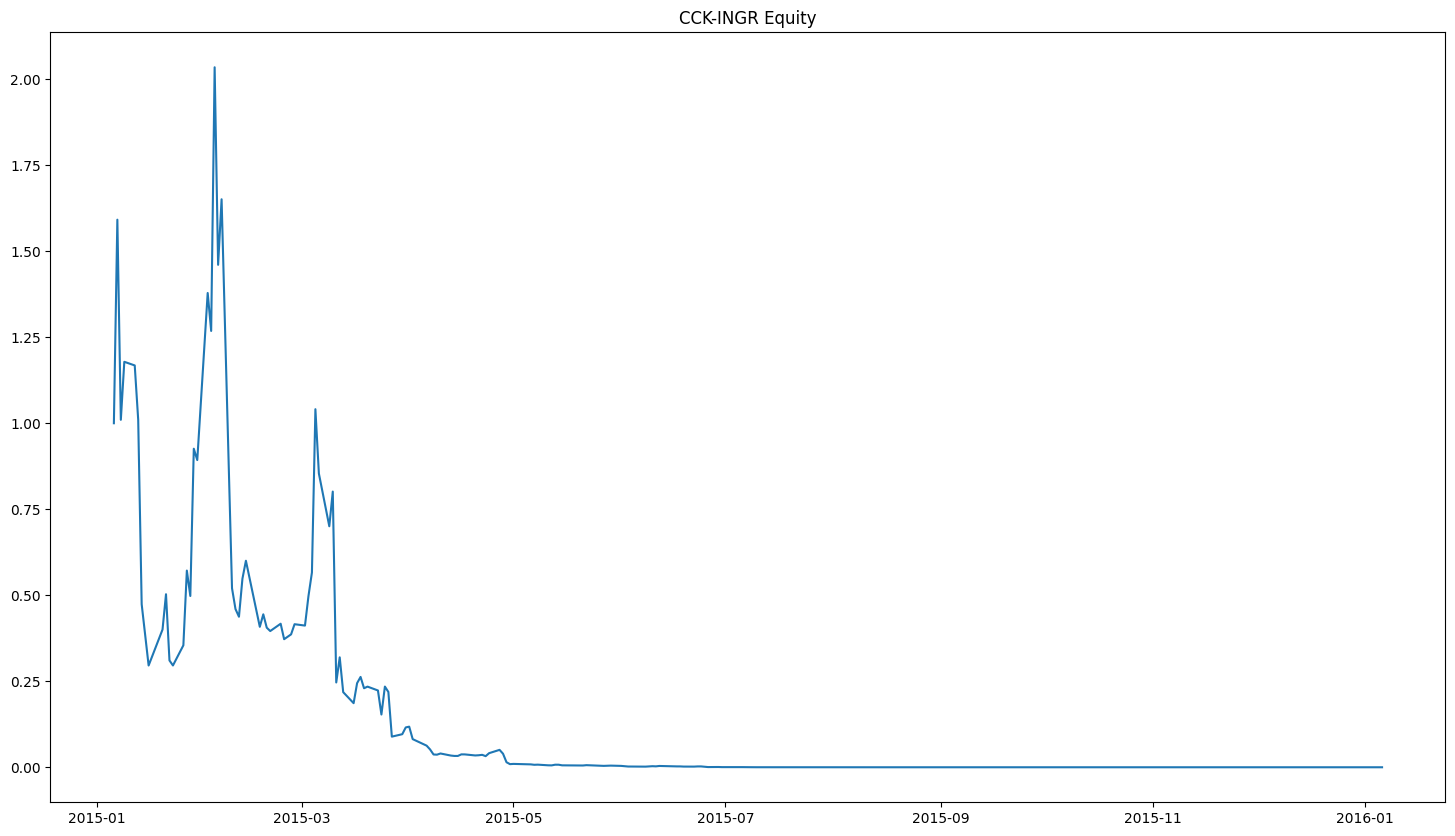

Total-Ret: -1.0000001818019217, Annual-Ret: nan, Sharpe: -0.4601855163700991, 
maxDD: -1.000017435747604, MaxDD-Duration: 232.0



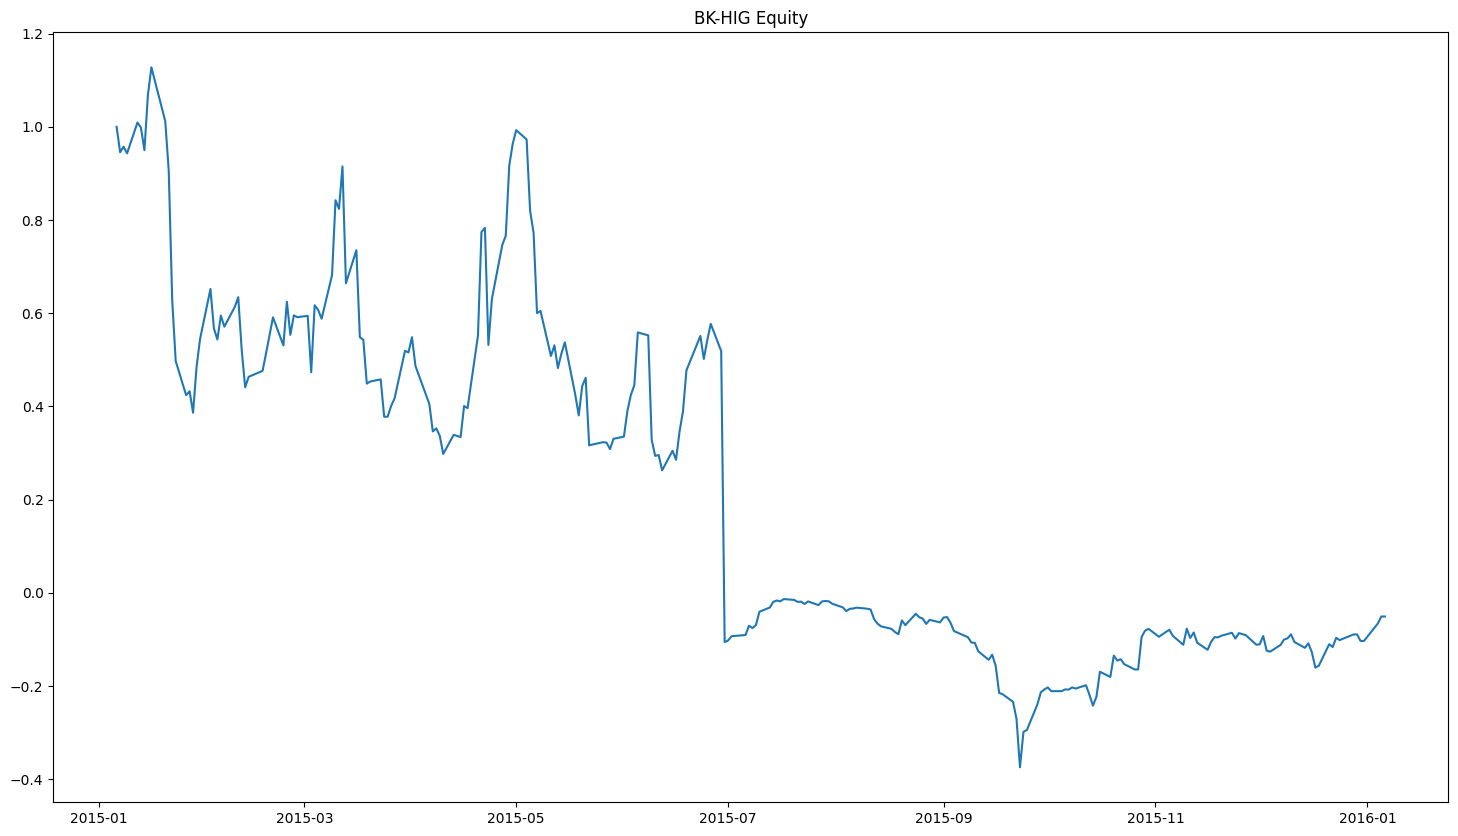

Total-Ret: -1.0506073185845701, Annual-Ret: nan, Sharpe: 0.3194806132260719, 
maxDD: -1.331717899806439, MaxDD-Duration: 244.0



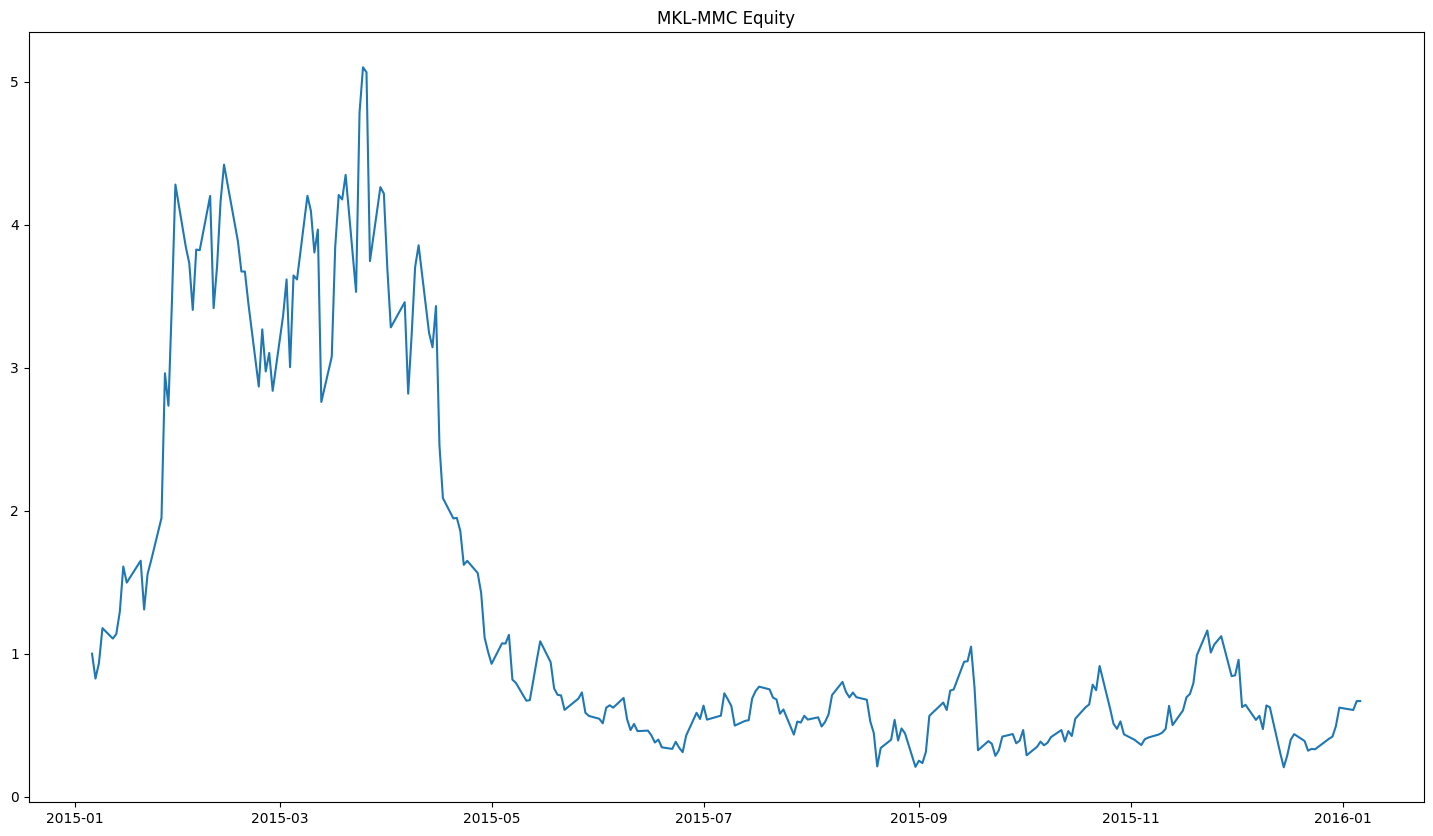

Total-Ret: -0.3319414228136016, Annual-Ret: -0.33087543062714664, Sharpe: 1.3755313776837035, 
maxDD: -0.9598319297703959, MaxDD-Duration: 198.0



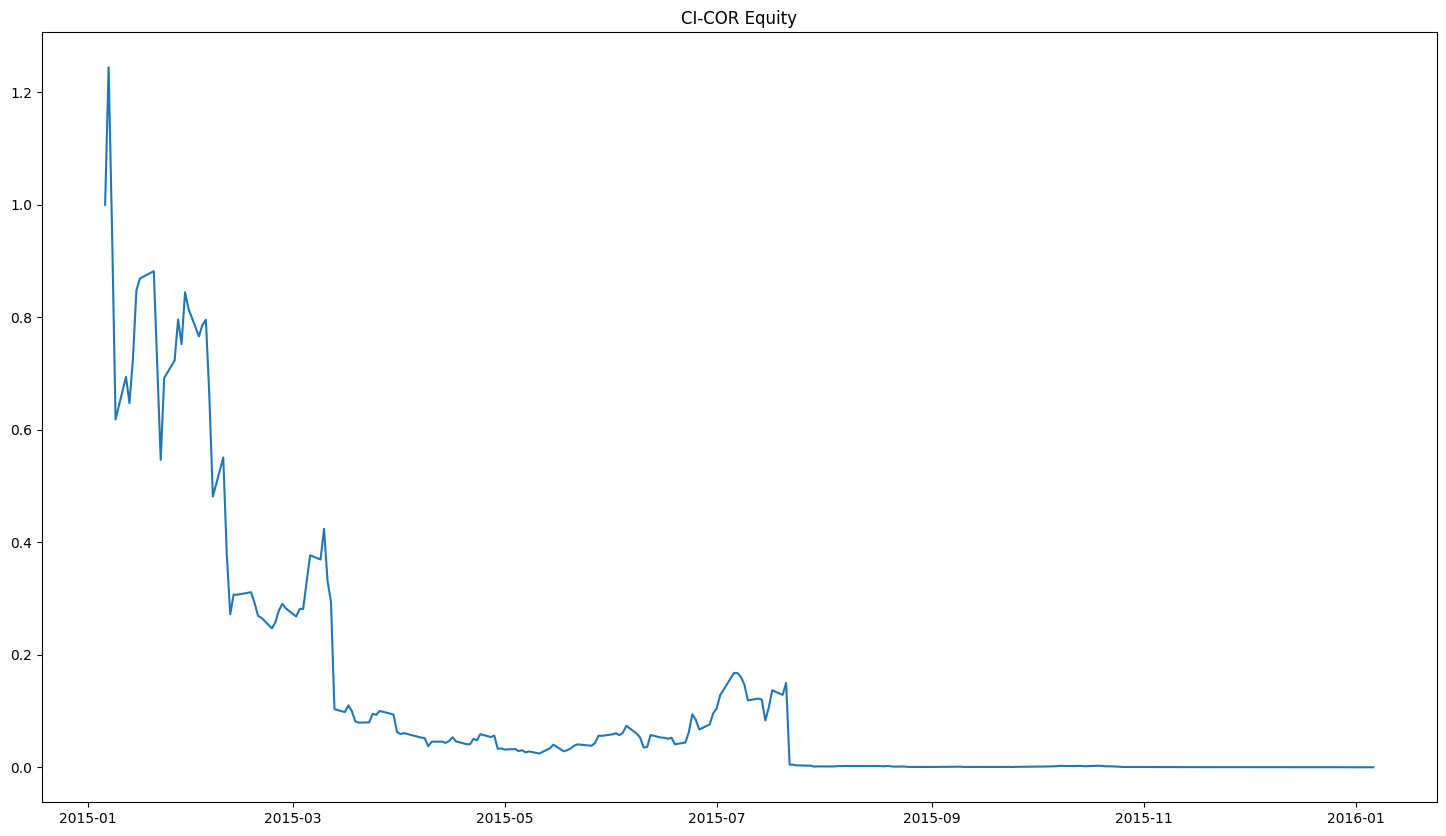

Total-Ret: -0.9999677798151807, Annual-Ret: -0.9999664353237958, Sharpe: -0.9460462352351705, 
maxDD: -0.9999741084719713, MaxDD-Duration: 251.0



In [14]:
for _, key in enumerate(list(backtest_result.keys())[:5]):
    temp = pd.concat(backtest_result[key], axis=0)
    # remove duplicates
    temp = temp[~temp.index.duplicated()]
    # calculate cumulative return
    cumret = np.nancumprod(1 + temp*20) # 20 Leverage
    # plot
    plt.figure(figsize=(18, 10))
    plt.plot(temp.index, cumret)
    plt.title(f"{key} Equity")
    plt.show()
    # calculate metrics
    total_return, apr, sharpe, maxDD, maxDDD = calculate_metrics(cumret)
    print(f"Total-Ret: {total_return}, Annual-Ret: {apr}, Sharpe: {sharpe}, \n"
          f"maxDD: {maxDD}, MaxDD-Duration: {maxDDD}")
    print()
    

# Performance Summary
Aside from a short first year of profitability, overall the strategy clearly appeared to not have a profitable edge, this can be speculated as the ARMA(1,1) model failed to accurately predict the next day's spread.    
One discernment can be drawn is perhaps the percentile thresholds were not set high enough to capture the true next day's significant changes, thus one can try a larger percentile range(i.e. 5th-95th). Additionally, various lengths for training and trading windows can be experimented. 

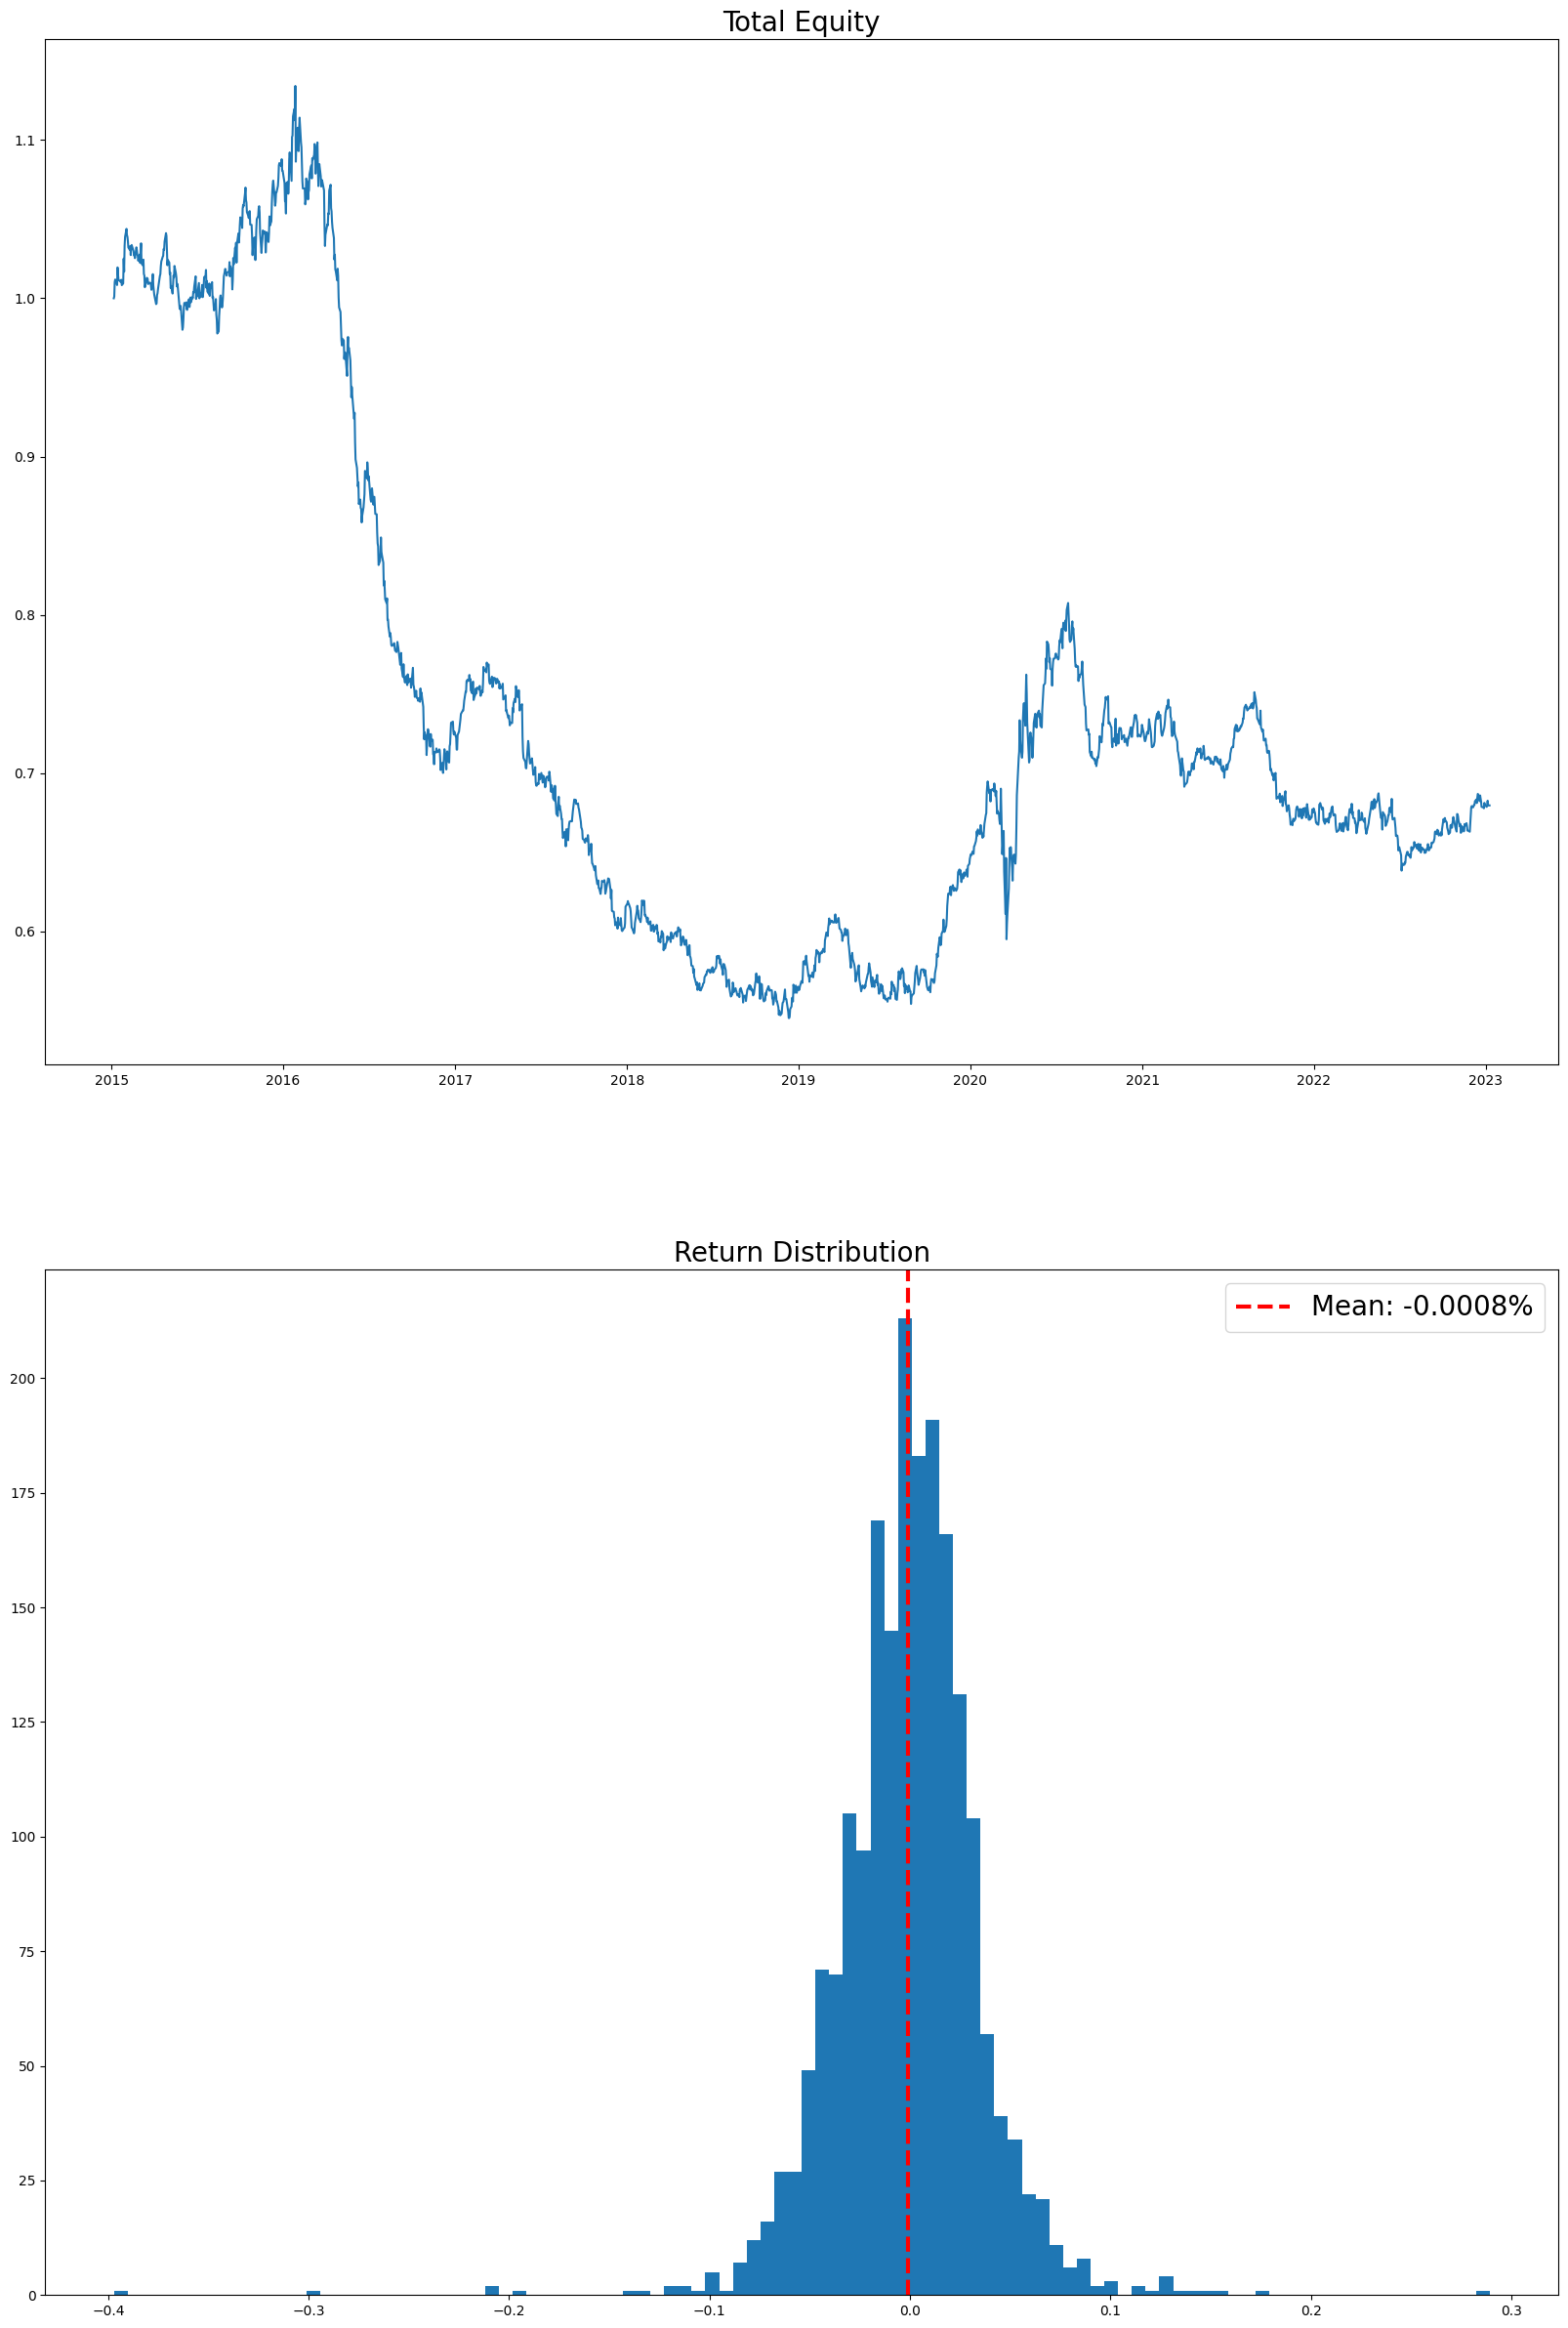

In [15]:
temp_equity = {}
for i in backtest_result.keys():
    backtest_result[i] = pd.concat(backtest_result[i])
    backtest_result[i] = backtest_result[i][~backtest_result[i].index.duplicated()]
    # remove euity[i] with all nan values
    if backtest_result[i].isnull().all():
        continue
    else:
        temp_equity[i] = backtest_result[i]
    
    
# concat all pd.Sereis in temp_equity, column-wise
df = pd.concat(temp_equity, axis=1)
df.columns = [key for key in temp_equity.keys()]
df.index = pd.to_datetime(df.index)
df.fillna(0, inplace=True)
df = df.sort_index()

num_pairs = len(df.columns)
# sum up the daily portfolio returns across all pairs
df['total'] = df.sum(axis=1) / num_pairs
# calculate the cumulative returns
cumret_main = np.nancumprod((df['total'] * 20) + 1) # 20 Leverage
# plot the total equity curve
expected_ret = df['total'].mean()
# plot the total equity curve
fig, ax = plt.subplots(2, 1, figsize=(20, 30))
ax[0].plot(df.index, cumret_main)
ax[0].set_title(f"Total Equity", fontsize=20)
# plot the histogram of the  pd series
ax[1].hist(df['total']*100, bins=100)
ax[1].axvline(expected_ret*100, ls='--', color='r', linewidth=3, label="Mean")
ax[1].set_title(f"Return Distribution", fontsize=20)
ax[1].legend([f"Mean: {round(expected_ret*100, 4)}%"], fontsize=20);

# Conclusion
This notebook demonstrates an empirical example of the pairs selection process outlined in Sarmento and Horta's [publication](https://www.springer.com/gp/book/9783030472504#aboutBook) to efficiently reduce the search space and select quality trading pairs. Roughly 13 years of daily stock prices from NYSE for 1326 securities were reduced to 15 dimensions through principal component analysis. Next, 2449 potential trading pairs were identified through OPTICS clustering and only **20** pairs from the clusters met the 5 selection criteria.

      
It then attempted to replicate one modification of the proposed trading methodology in the author's related [paper](http://premio-vidigal.inesc.pt/pdf/SimaoSarmentoMSc-resumo.pdf). Despite a rigour pair selection procedure, the trading methodology, on this particular dataset, did not indicate a profitable edge.